# Introduction

The notebook is designed for spatial transcriptomics analysis using the Visium platform. It processes and visualizes spatial gene expression data with tools like scanpy and matplotlib. The notebook guides users through downloading and preparing the dataset, loading it into memory, and performing preprocessing steps such as selecting highly variable genes, dimensionality reduction (PCA and UMAP), and clustering using the Leiden algorithm. It also includes visualization of clusters and spatial gene expression mapped onto tissue images.

Additionally, the notebook explores differential gene expression across clusters and investigates spatial topics using predefined labels. It provides tools to analyze specific genes, tumor suppressors, and cell cycle inhibitors, offering insights into tissue-specific gene expression patterns and biological processes. This notebook is ideal for researchers studying spatial transcriptomics, enabling clustering, visualization, and biological interpretation of spatial gene expression data.

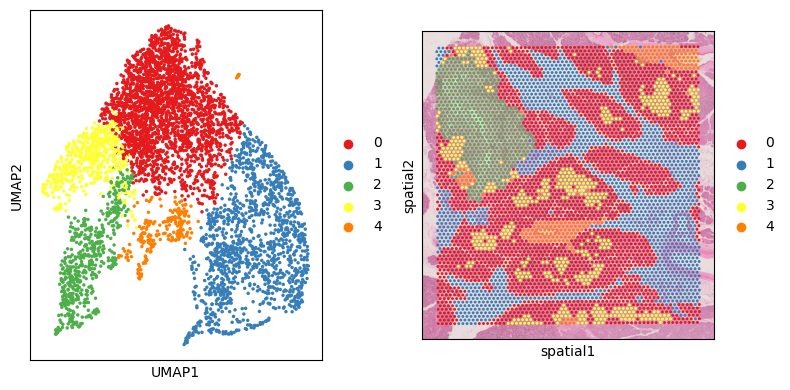

# Code

To get started, download the dataset (~400 MB) from the provided Zenodo repository, then extract (unpack) 
the contents to a local directory on your machine. After unpacking, locate the variable named dataPath 
in the cell below and update its value to point to the folder where you extracted the data. Once you've 
set the correct path, you can run the subsequent jupyter notebook cells.

In [ ]:
!curl -L "https://zenodo.org/api/records/15786116/files-archive" -o dataset.zip && unzip dataset.zip && rm dataset.zip

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import cm
import matplotlib.pyplot as plt

palette1={str(k):cm.Set1(k) for k in range(8)}
palette1.update({str(k):cm.Set2(k-8) for k in range(8,16)})
palette1.update({str(3):cm.Set1(5), str(5):cm.Set1(3), str(8):cm.Set2(0), str(7):'cyan', str(6):cm.Set1(7)})

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
dataPath = './'

ad = sc.read(dataPath + 'visium-JDC-WP-012-w.h5ad')
ad = ad[:, ad.var.index[~ad.var.index.str.contains('DEPRECATED_')]]

In [ ]:
# Select highly variable genes
sc.pp.highly_variable_genes(ad, flavor='seurat', n_top_genes=2500)

# Compute PCA
sc.pp.pca(ad, n_comps=50, zero_center=True, use_highly_variable=True)

# Compute neighbors graph
sc.pp.neighbors(ad, use_rep='X_pca')

# Compute UMAP embedding
sc.tl.umap(ad)

# Compute clusters using Leiden algorithm
sc.tl.leiden(ad, key_added='clusters', resolution=0.2)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.umap(ad, color=['clusters'], s=25, palette=palette1, ax=axs[0], show=False, title='')
sc.pl.spatial(ad, color=['clusters'], ax=axs[1], palette=palette1, img_key='hires', show=False, title='')
plt.tight_layout()
plt.show()

In [ ]:
# Compute differential expression
sc.tl.rank_genes_groups(ad, groupby='clusters', method='wilcoxon')

# Visualize differential expression per cluster
sc.tl.dendrogram(ad, groupby='clusters')
sc.pl.rank_genes_groups_heatmap(ad, groupby='clusters', show_gene_labels=True, n_genes=10, cmap='viridis')

In [ ]:
plt.rcParams["figure.figsize"] = (3,3)
sc.pl.spatial(ad, color=['MUC6', 'MUC5AC', 'GNMT', 'PPY', 'VIM', 'GATM'], wspace=0.1, ncols=3)

In [ ]:
plt.rcParams["figure.figsize"] = (3,3)
sc.pl.spatial(ad, color=['CCND1', 'CDKN1A', 'CDKN2A'], wspace=0.1, ncols=3) # CDKN2A tummor suppresssor, CDKN1A cell cycle inhibitor

## Explore topics of spatial gene expression

STdeconvolve is a computational tool for reference-free cell type deconvolution of spatially resolved transcriptomics (ST) data at multi-cellular pixel resolution. It identifies latent transcriptional topics, which represent groups of co-expressed genes associated with distinct biological processes or cell types, without requiring prior knowledge or reference datasets. These topics enable researchers to uncover spatially organized cellular heterogeneity and tissue-specific gene expression patterns. The implementation used here, available at The Jackson Laboratory's GitHub repository (https://github.com/TheJacksonLaboratory/ST-downstream-processing), facilitates downstream analysis of spatial topics and their associated genes. For more information, refer to the paper: "Reference-free cell type deconvolution of multi-cellular pixel-resolution spatially resolved transcriptomics data" by Miller et al., 2022.

In [ ]:
# STdeconvolve topics definitions constitute a set of genes that are co-expressed in a specific spatial pattern.
# Each gene is associated with all topics via weights:
df_topic_def = pd.read_csv(dataPath + 'visium-JDC-WP-012-w-topics.csv', index_col=0)
df_topic_def.head().style.background_gradient(cmap='Blues')

In [ ]:
plt.rcParams["figure.figsize"] = (3,3)
topics = ['Topic LDA 1', 'Topic LDA 2', 'Topic LDA 3', 'Topic LDA 4', 'Topic LDA 5', 'Topic LDA 6', 'Topic LDA 7', 'Topic LDA 8', 'Topic LDA 9']
sc.pl.spatial(ad, color=topics, wspace=0.1, ncols=5)

### Topic 1: Islet of Langerhans

In [ ]:
genes = df_topic_def['1'].sort_values(ascending=False).head(4).index.values.tolist()

plt.rcParams["figure.figsize"] = (3,3)
sc.pl.spatial(ad, color=genes, wspace=0.1, ncols=4)

### Topic 5: Acinar to ductal metaplasia (ADM)

In [ ]:
genes = df_topic_def['5'].sort_values(ascending=False).head(4).index.values.tolist()

plt.rcParams["figure.figsize"] = (3,3)
sc.pl.spatial(ad, color=genes, wspace=0.1, ncols=4)

### Topic 7: Vascular structures

In [ ]:
genes = df_topic_def['7'].sort_values(ascending=False).head(4).index.values.tolist()

plt.rcParams["figure.figsize"] = (3,3)
sc.pl.spatial(ad, color=genes, wspace=0.1, ncols=4)